In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc_absolute
%store -r Y_relative_footsteps_acc_absolute
print(X_relative_footsteps_acc_absolute.shape)
print(Y_relative_footsteps_acc_absolute.shape)

(9780, 28)
(9780, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
X_relative_footsteps_acc_absolute[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [8]:
## Entries where FL is swinging
idxs = np.where(X_relative_footsteps_acc_absolute[:, 21] == 1)[0]
X_relative_footsteps_acc_absolute_FL_swinging = X_relative_footsteps_acc_absolute[idxs]
Y_relative_footsteps_acc_absolute_FL_swinging = Y_relative_footsteps_acc_absolute[idxs]

## Predict FL foot -> x

In [9]:
X_relative_footsteps_acc_absolute_FL_swinging.shape

(4892, 28)

In [10]:
#X_relative_footsteps_acc_absolute_FL_swinging[:10, :]

In [11]:
Y_relative_footsteps_acc_absolute_FL_swinging[0, :]

array([-3.85098328e-04, -3.36410252e-03,  5.40918657e-03,  1.06705281e-05])

### Linear Regression

In [20]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_FL_swinging[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_FL_swinging[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_FL_swinging[:, 3:9], # felt velocities
               X_relative_footsteps_acc_absolute_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9376979810630571
RMSE:  0.019426174707538976
The lowest error is:  1.6336837083408273e-05
The highest error is:  0.12906077961272688
The avg. error is:  0.012481646134749788


In [21]:
model_fl_relative_support_x.coef_

array([[ 0.02794777,  0.14745849, -0.0099802 ,  0.16896836, -0.00317766,
        -0.08281088, -0.09435835, -0.02468664, -0.10105576,  0.02259302,
         0.03871974, -0.11436175, -0.21688816, -0.3986449 , -0.47509376,
        -0.62164082,  1.34839686, -1.06940215, -1.00513338, -0.39709677]])

In [22]:
model_fl_relative_support_x.intercept_

array([0.32196497])

Text(0, 0.5, 'Predictions')

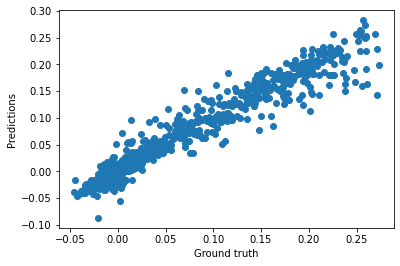

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_relative_support_x

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [31]:
# Input
X = np.hstack((X_relative_footsteps_acc_absolute_FL_swinging[:, :3], # prev velocity command
               X_relative_footsteps_acc_absolute_FL_swinging[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_absolute_FL_swinging[:, 3:9], # felt velocities
               X_relative_footsteps_acc_absolute_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_absolute_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_absolute_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_absolute_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_absolute_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.902452793007951
RMSE:  0.015041765165927997
The lowest error is:  2.024969089131634e-06
The highest error is:  0.08087654498074401
The avg. error is:  0.008999896410171414


In [32]:
model_fl_relative_support_y.coef_

array([[ 0.04249836,  0.1745788 ,  0.10035121, -0.01451949,  0.15749015,
         0.06894747,  0.02260231, -0.10489863, -0.02254711,  0.00690144,
         0.02645862, -0.0943537 ,  0.2461572 , -0.30928044, -0.19689506,
         0.42849008, -0.07621504, -0.57697278, -0.07445186, -0.25892667]])

In [33]:
model_fl_relative_support_y.intercept_

array([0.13019219])

Text(0, 0.5, 'Predictions')

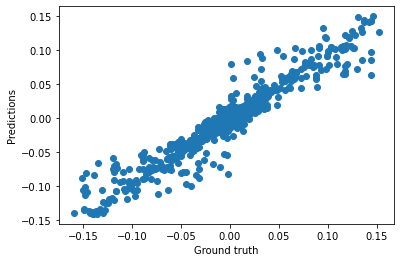

In [34]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [56]:
#%store model_fl_relative_support_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")